In [1]:

from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from typing import *
from PIL import Image

import matplotlib.pyplot as plt
import time, os, copy, pickle
import pandas as pd
import seaborn as sns
import numpy as np
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  2.1.0+cu121
Torchvision Version:  0.16.0+cu121


## Prepare data to validate Our Model

In [2]:
MODEL_NAME = 'weights/model_pytorch_correct_full_200epochs.pt'
DATASET_DIR = '../datasets/MIT_split'

BATCH_SIZE = 16
IMG_SIZE = (256, 256)
NUM_CLASSES = 8

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # zero-centered
])

In [3]:
# Create training and validation datasets
test_dataset = datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform)
# Create training and validation dataloaders
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


### Recovering the model 

In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 29, 3)
        self.batchnorm1 = nn.BatchNorm2d(29)
        self.conv2 = nn.Conv2d(29, 1, 3)
        self.batchnorm2 = nn.BatchNorm2d(1)
        self.conv3 = nn.Conv2d(1, 14, 3)
        self.batchnorm3 = nn.BatchNorm2d(14)
        self.conv4 = nn.Conv2d(14, 19, 3)
        self.batchnorm4 = nn.BatchNorm2d(19)
        self.conv5 = nn.Conv2d(19, 27, 3)
        self.batchnorm5 = nn.BatchNorm2d(27)
        self.fc_output = nn.Linear(27, NUM_CLASSES)

        self.max_pool = nn.MaxPool2d(3)
        self.glob_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout2d(0.1)

        self.softmax = nn.Softmax()
        
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.max_pool(self.batchnorm2(F.relu(self.conv2(x))))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.dropout(x) if self.training else x
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = self.dropout(x) if self.training else x
        x = self.batchnorm5(F.relu(self.conv5(x)))
        x = self.dropout(x) if self.training else x
  
        x = self.glob_avg_pool(x)
        # Flatten the tensor to (batch_size, num_channels)
        x = x.view(x.size(0), -1)  
        x = self.softmax(self.fc_output(x))
        
        return x
    
model = Model().to(device)

In [5]:
!pwd

/home/cboned/Desktop/Master/MCV-C5-G1/Week1


In [6]:
model.load_state_dict(torch.load(MODEL_NAME))


<All keys matched successfully>

In [7]:
import pickle, copy

## Applying GradCam adn explainability

In [133]:
@torch.no_grad()  # prevent this function from computing gradients 
def get_mistakes(model, loader):
    

    val_loss = 0
    correct = 0

    model.eval()
    final_images = []
    final_targets =  []
    errors_im = []
    predictions = []

    for data, target in loader:
        data, target = data.to(device), target.to(device)
    
        output = model(data)
        p = F.softmax(output, dim=1)
        scr, pred = p.data.max(1, keepdim=True) # get the index of the max log-probability   
        
        predictions += (list(pred.cpu().numpy()))
        correct += pred.eq(target.view_as(pred)).sum().item()
        non_correcte = (pred != target.view_as(pred)).squeeze() 
        image_indexes = data[non_correcte,:,:,:]
        image_targets = target[non_correcte]

        errors = pred[non_correcte]
    
        final_images.append(image_indexes.cpu())
        final_targets.append(image_targets.cpu().numpy())
        errors_im.append(errors.cpu().numpy())

    return final_images, final_targets, errors_im

@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        _, preds = torch.max(outputs, 1)
    

    
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
        
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("test", epoch_loss, epoch_acc))

In [9]:
criterion = torch.nn.CrossEntropyLoss()

In [10]:
validate(model=model.cuda(), criterion=criterion, loader=test_dataloader)

/home/cboned/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


test Loss: 1.5102 Acc: 0.7571


In [134]:
#model._freeze = True
misatke_images, gt, predictions = get_mistakes(model=model, loader=test_dataloader)

/home/cboned/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [135]:
misatke_images

[tensor([[[[-0.6863, -0.6784, -0.8510,  ..., -0.6235, -0.6235, -0.6235],
           [-0.7255, -0.7176, -0.7412,  ..., -0.6235, -0.6235, -0.6235],
           [-0.6784, -0.7176, -0.7176,  ..., -0.6157, -0.6157, -0.6157],
           ...,
           [-0.8824, -0.8745, -0.8824,  ...,  0.9137,  0.8118,  0.4667],
           [-0.8745, -0.8745, -0.8824,  ...,  0.8745,  0.7961,  0.4196],
           [-0.8745, -0.8745, -0.8824,  ...,  0.7020,  0.6784,  0.9059]],
 
          [[-0.5216, -0.5137, -0.6863,  ..., -0.3569, -0.3569, -0.3647],
           [-0.5608, -0.5529, -0.5608,  ..., -0.3569, -0.3569, -0.3569],
           [-0.4824, -0.5216, -0.5059,  ..., -0.3490, -0.3490, -0.3490],
           ...,
           [-0.9686, -0.9608, -0.9529,  ...,  0.5608,  0.4353,  0.0902],
           [-0.9686, -0.9608, -0.9529,  ...,  0.5294,  0.4275,  0.0353],
           [-0.9686, -0.9608, -0.9529,  ...,  0.3647,  0.3176,  0.5294]],
 
          [[-0.3098, -0.2863, -0.4588,  ...,  0.2235,  0.2235,  0.2392],
           [-

In [136]:
def tensor_to_image(img):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                    transforms.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                         std = [ 1., 1., 1. ]),
                                   ])
    img = invTrans(img)
    img = img.permute(1, 2, 0) 
    img = (img.numpy()*255).astype(np.uint8)
    return img #Image.fromarray(tensor, "RGB")

convert_tensor = transforms.ToTensor()

inverse_mapping_classes = {j:i for i, j in test_dataloader.dataset.class_to_idx.items()}

In [137]:
(misatke_images[3].shape)

torch.Size([2, 3, 256, 256])

In [138]:
predictions = [i for i in predictions if len(i) != 0 ]
images_test = [(i) for i in misatke_images if len(i) != 0 ]
gt_test = [i for i in gt if len(i) != 0]

In [139]:
predictions[0]
print(gt_test[0])
inverse_mapping_classes[1]
print(inverse_mapping_classes[0])



[5 3]
Opencountry


In [140]:
predictions[0][0].item()

1

In [428]:
bath_idx = 16
error_image = 0

In [429]:
error_what = predictions[bath_idx][error_image]
good_what = gt[bath_idx][error_image]

In [430]:
print(f'Model_predicted: {inverse_mapping_classes[predictions[bath_idx][error_image].item()]}')
print(f'Ground_truth: {inverse_mapping_classes[gt[bath_idx][error_image].item()]}')


Model_predicted: mountain
Ground_truth: street


In [431]:
img_test = tensor_to_image(images_test[bath_idx][error_image])

## Silency Representation

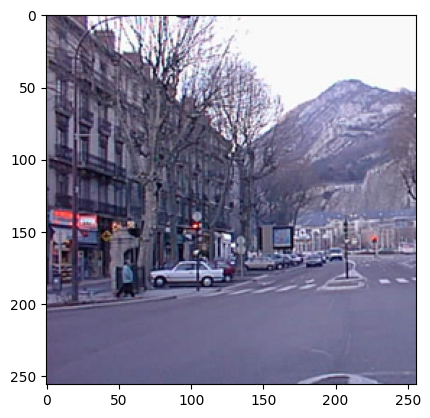

In [432]:
plt.imshow(img_test)

In [433]:
X = convert_tensor(img_test).unsqueeze(0).requires_grad_()

In [434]:
scores = model(X.to(device))
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

/home/cboned/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [435]:
score_max.backward()

In [436]:
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

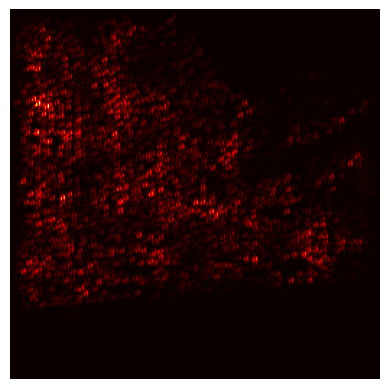

In [437]:
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

## On gradcam representation

In [484]:
target_layers = [model.conv1]
input_tensor = X

In [485]:
cam  = GradCAM(model=model, target_layers=target_layers)

In [486]:
print(error_what)
print(good_what)

[5]
6


In [487]:
inverse_mapping_classes

{0: 'Opencountry',
 1: 'coast',
 2: 'forest',
 3: 'highway',
 4: 'inside_city',
 5: 'mountain',
 6: 'street',
 7: 'tallbuilding'}

In [488]:
targets = [ClassifierOutputTarget([error_what])]

grayscale_cam = cam(input_tensor=X, targets=targets)


/home/cboned/.local/lib/python3.8/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [489]:
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)

(256, 256)


In [490]:
visualization = show_cam_on_image(img_test/255, grayscale_cam, use_rgb=True)


In [491]:
model_outputs = cam.outputs

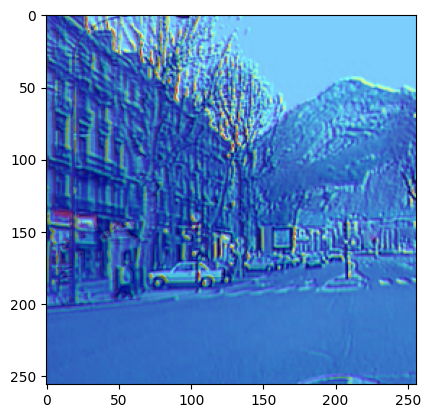

In [492]:
plt.imshow(visualization)